# Use keras-tuner to optimize model on TriFeature data for multiplicity determination

In [1]:
import sys

import numpy as np
import pandas as pd

sys.path.append("..")
from helpers import filename_for

In [2]:
import kerastuner
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)
print("keras-tuner", kerastuner.__version__)

tensorflow 2.3.1
keras 2.4.0
keras-tuner 1.0.1


In [3]:
num_dp = 30
max_neutrons = 4
label = "nPH"

In [4]:
files = [
    filename_for(15, 30, 600, 500, n, "inclxx", s, "trifeature.parquet")
    for n in range(1, max_neutrons + 1)
    for s in range(20)
]
dfs = [pd.read_parquet(file) for file in files]
data = pd.concat(dfs, ignore_index=True).sample(frac=1)
print(data.shape)

(800000, 6)


In [5]:
msk = np.random.rand(len(data)) < 0.8
# Create one entry with zero everything to prevent NaN-PDF if no entry with LABEL=0 exists
msk[0] = True
data.loc[0] = [0, 0, 0, 0, 0, 0]
traindata = data[msk]
testdata = data[~msk]

print(traindata.shape)
print(testdata.shape)

x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

x_val = testdata[["nHits", "nClus", "Edep"]].values
y_val = keras.utils.to_categorical(testdata[[label]].values.ravel());

(640320, 6)
(159680, 6)


In [6]:
def build_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("unitsl1", min_value=10, max_value=500, step=10), activation="relu", input_shape=(3,),
        )
    )
    model.add(keras.layers.Dense(units=hp.Int("unitsl2", min_value=5, max_value=50, step=5), activation="relu",))
    model.add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

    optimizer = keras.optimizers.Adam()  # hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4]))
    loss = keras.losses.CategoricalCrossentropy()
    model.compile(loss=loss, optimizer=optimizer, metrics=["acc"])
    return model

In [7]:
tuner = kerastuner.tuners.RandomSearch(
    build_model,
    objective="val_acc",
    max_trials=50,
    executions_per_trial=3,
    directory="out",
    project_name="simple-tuner",
)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project out\simple-tuner\oracle.json


In [8]:
tuner.search(
    x_train, y_train, epochs=5, batch_size=2000, validation_data=(x_val, y_val), verbose=2,
)

Epoch 1/5
321/321 - 1s - loss: 3.6878 - acc: 0.2944 - val_loss: 1.2512 - val_acc: 0.3486
Epoch 2/5
321/321 - 1s - loss: 0.9646 - acc: 0.6528 - val_loss: 0.8010 - val_acc: 0.7779
Epoch 3/5
321/321 - 1s - loss: 0.7135 - acc: 0.7763 - val_loss: 0.6517 - val_acc: 0.7853
Epoch 4/5
321/321 - 1s - loss: 0.5944 - acc: 0.7850 - val_loss: 0.5841 - val_acc: 0.7414
Epoch 5/5
321/321 - 1s - loss: 0.5457 - acc: 0.7853 - val_loss: 0.5286 - val_acc: 0.7886
Epoch 1/5
321/321 - 1s - loss: 5.4312 - acc: 0.4229 - val_loss: 0.9874 - val_acc: 0.5628
Epoch 2/5
321/321 - 1s - loss: 0.8584 - acc: 0.6239 - val_loss: 0.8267 - val_acc: 0.5939
Epoch 3/5
321/321 - 1s - loss: 0.6356 - acc: 0.7405 - val_loss: 0.6096 - val_acc: 0.7209
Epoch 4/5
321/321 - 1s - loss: 0.5672 - acc: 0.7619 - val_loss: 0.5240 - val_acc: 0.7873
Epoch 5/5
321/321 - 1s - loss: 0.5429 - acc: 0.7725 - val_loss: 0.5239 - val_acc: 0.7892
Epoch 1/5
321/321 - 1s - loss: 3.0628 - acc: 0.2821 - val_loss: 1.4335 - val_acc: 0.4080
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 3.8496 - acc: 0.3359 - val_loss: 1.1580 - val_acc: 0.4403
Epoch 2/5
321/321 - 1s - loss: 1.0776 - acc: 0.5190 - val_loss: 0.9620 - val_acc: 0.5535
Epoch 3/5
321/321 - 1s - loss: 0.8769 - acc: 0.6485 - val_loss: 0.8378 - val_acc: 0.6440
Epoch 4/5
321/321 - 1s - loss: 0.7452 - acc: 0.7097 - val_loss: 0.6824 - val_acc: 0.7416
Epoch 5/5
321/321 - 1s - loss: 0.6801 - acc: 0.7202 - val_loss: 0.6215 - val_acc: 0.7869
Epoch 1/5
321/321 - 1s - loss: 5.5494 - acc: 0.3828 - val_loss: 1.1224 - val_acc: 0.4693
Epoch 2/5
321/321 - 1s - loss: 1.0416 - acc: 0.5493 - val_loss: 0.9624 - val_acc: 0.5497
Epoch 3/5
321/321 - 1s - loss: 0.8995 - acc: 0.6253 - val_loss: 0.9201 - val_acc: 0.5643
Epoch 4/5
321/321 - 1s - loss: 0.7568 - acc: 0.6815 - val_loss: 0.7640 - val_acc: 0.6475
Epoch 5/5
321/321 - 1s - loss: 0.6340 - acc: 0.7471 - val_loss: 0.5995 - val_acc: 0.7795
Epoch 1/5
321/321 - 1s - loss: 4.4299 - acc: 0.3639 - val_loss: 1.0797 - val_acc: 0.4678
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 4.9030 - acc: 0.4550 - val_loss: 1.0220 - val_acc: 0.4930
Epoch 2/5
321/321 - 1s - loss: 0.8146 - acc: 0.6599 - val_loss: 0.8093 - val_acc: 0.6459
Epoch 3/5
321/321 - 1s - loss: 0.7894 - acc: 0.7050 - val_loss: 0.7349 - val_acc: 0.6565
Epoch 4/5
321/321 - 1s - loss: 0.6111 - acc: 0.7370 - val_loss: 0.5508 - val_acc: 0.7860
Epoch 5/5
321/321 - 1s - loss: 0.5561 - acc: 0.7657 - val_loss: 0.5322 - val_acc: 0.7685
Epoch 1/5
321/321 - 1s - loss: 3.3729 - acc: 0.4913 - val_loss: 0.8424 - val_acc: 0.6089
Epoch 2/5
321/321 - 1s - loss: 0.7265 - acc: 0.6850 - val_loss: 0.5657 - val_acc: 0.7506
Epoch 3/5
321/321 - 1s - loss: 0.6112 - acc: 0.7437 - val_loss: 0.5481 - val_acc: 0.7778
Epoch 4/5
321/321 - 1s - loss: 0.5925 - acc: 0.7492 - val_loss: 0.5548 - val_acc: 0.7446
Epoch 5/5
321/321 - 1s - loss: 0.5401 - acc: 0.7727 - val_loss: 0.6050 - val_acc: 0.7064
Epoch 1/5
321/321 - 1s - loss: 2.6845 - acc: 0.4347 - val_loss: 0.7903 - val_acc: 0.6957
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 4.0977 - acc: 0.4536 - val_loss: 0.7538 - val_acc: 0.7150
Epoch 2/5
321/321 - 1s - loss: 0.7900 - acc: 0.6809 - val_loss: 0.6535 - val_acc: 0.7800
Epoch 3/5
321/321 - 1s - loss: 0.7170 - acc: 0.7159 - val_loss: 0.5860 - val_acc: 0.7436
Epoch 4/5
321/321 - 1s - loss: 0.5604 - acc: 0.7711 - val_loss: 3.6140 - val_acc: 0.5164
Epoch 5/5
321/321 - 1s - loss: 0.9205 - acc: 0.7105 - val_loss: 0.6160 - val_acc: 0.7884
Epoch 1/5
321/321 - 1s - loss: 3.4640 - acc: 0.2937 - val_loss: 1.2236 - val_acc: 0.4248
Epoch 2/5
321/321 - 1s - loss: 1.3755 - acc: 0.2864 - val_loss: 1.3654 - val_acc: 0.2804
Epoch 3/5
321/321 - 1s - loss: 1.3541 - acc: 0.2971 - val_loss: 1.3648 - val_acc: 0.2793
Epoch 4/5
321/321 - 1s - loss: 1.3565 - acc: 0.2906 - val_loss: 1.3562 - val_acc: 0.2835
Epoch 5/5
321/321 - 1s - loss: 1.3502 - acc: 0.2924 - val_loss: 1.3227 - val_acc: 0.3167
Epoch 1/5
321/321 - 1s - loss: 5.2009 - acc: 0.4358 - val_loss: 0.8571 - val_acc: 0.6837
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.5513 - acc: 0.2663 - val_loss: 1.3692 - val_acc: 0.3052
Epoch 2/5
321/321 - 1s - loss: 1.3710 - acc: 0.2876 - val_loss: 1.3650 - val_acc: 0.2831
Epoch 3/5
321/321 - 1s - loss: 1.3565 - acc: 0.2898 - val_loss: 1.3463 - val_acc: 0.2945
Epoch 4/5
321/321 - 1s - loss: 1.3836 - acc: 0.2773 - val_loss: 1.3675 - val_acc: 0.2773
Epoch 5/5
321/321 - 1s - loss: 1.3659 - acc: 0.2749 - val_loss: 1.3659 - val_acc: 0.2735
Epoch 1/5
321/321 - 1s - loss: 2.4219 - acc: 0.2778 - val_loss: 1.3889 - val_acc: 0.2777
Epoch 2/5
321/321 - 1s - loss: 1.4741 - acc: 0.2814 - val_loss: 1.3667 - val_acc: 0.2802
Epoch 3/5
321/321 - 1s - loss: 1.3534 - acc: 0.2942 - val_loss: 1.3607 - val_acc: 0.2825
Epoch 4/5
321/321 - 1s - loss: 1.3562 - acc: 0.2939 - val_loss: 1.3615 - val_acc: 0.2783
Epoch 5/5
321/321 - 1s - loss: 1.3574 - acc: 0.2852 - val_loss: 1.3475 - val_acc: 0.3018
Epoch 1/5
321/321 - 1s - loss: 2.0114 - acc: 0.2873 - val_loss: 1.3848 - val_acc: 0.2771
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 2s - loss: 2.0196 - acc: 0.2499 - val_loss: 1.5348 - val_acc: 0.2570
Epoch 2/5
321/321 - 1s - loss: 1.4970 - acc: 0.2686 - val_loss: 1.4712 - val_acc: 0.2771
Epoch 3/5
321/321 - 1s - loss: 1.4575 - acc: 0.2798 - val_loss: 1.4424 - val_acc: 0.2740
Epoch 4/5
321/321 - 1s - loss: 1.4481 - acc: 0.2750 - val_loss: 1.4209 - val_acc: 0.2767
Epoch 5/5
321/321 - 2s - loss: 1.4070 - acc: 0.2826 - val_loss: 1.4031 - val_acc: 0.2811
Epoch 1/5
321/321 - 1s - loss: 2.0085 - acc: 0.2711 - val_loss: 1.4864 - val_acc: 0.3079
Epoch 2/5
321/321 - 1s - loss: 1.4793 - acc: 0.2914 - val_loss: 1.4969 - val_acc: 0.2666
Epoch 3/5
321/321 - 1s - loss: 1.4615 - acc: 0.2967 - val_loss: 1.4549 - val_acc: 0.2878
Epoch 4/5
321/321 - 1s - loss: 1.4273 - acc: 0.3036 - val_loss: 1.4546 - val_acc: 0.2698
Epoch 5/5
321/321 - 1s - loss: 1.4333 - acc: 0.2888 - val_loss: 1.4326 - val_acc: 0.2836
Epoch 1/5
321/321 - 1s - loss: 2.5373 - acc: 0.3988 - val_loss: 1.0113 - val_acc: 0.5249
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.5432 - acc: 0.3881 - val_loss: 1.5750 - val_acc: 0.4653
Epoch 2/5
321/321 - 1s - loss: 1.2793 - acc: 0.5397 - val_loss: 0.8014 - val_acc: 0.6720
Epoch 3/5
321/321 - 2s - loss: 1.0905 - acc: 0.6064 - val_loss: 0.8584 - val_acc: 0.6744
Epoch 4/5
321/321 - 1s - loss: 0.7617 - acc: 0.6789 - val_loss: 1.2770 - val_acc: 0.5728
Epoch 5/5
321/321 - 1s - loss: 0.7597 - acc: 0.6664 - val_loss: 0.9403 - val_acc: 0.6181
Epoch 1/5
321/321 - 1s - loss: 2.4003 - acc: 0.3390 - val_loss: 3.1951 - val_acc: 0.2891
Epoch 2/5
321/321 - 1s - loss: 1.1624 - acc: 0.5182 - val_loss: 1.4420 - val_acc: 0.5242
Epoch 3/5
321/321 - 1s - loss: 1.0041 - acc: 0.6010 - val_loss: 0.8472 - val_acc: 0.5803
Epoch 4/5
321/321 - 2s - loss: 0.7690 - acc: 0.6713 - val_loss: 0.7297 - val_acc: 0.6859
Epoch 5/5
321/321 - 1s - loss: 0.8241 - acc: 0.6506 - val_loss: 0.8276 - val_acc: 0.6351
Epoch 1/5
321/321 - 1s - loss: 2.0530 - acc: 0.3920 - val_loss: 1.1930 - val_acc: 0.4850
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 6.7080 - acc: 0.4516 - val_loss: 1.5726 - val_acc: 0.4835
Epoch 2/5
321/321 - 1s - loss: 0.8342 - acc: 0.6419 - val_loss: 0.7467 - val_acc: 0.6527
Epoch 3/5
321/321 - 1s - loss: 0.6598 - acc: 0.7203 - val_loss: 0.6068 - val_acc: 0.7226
Epoch 4/5
321/321 - 1s - loss: 0.5799 - acc: 0.7566 - val_loss: 0.5886 - val_acc: 0.7467
Epoch 5/5
321/321 - 1s - loss: 0.5702 - acc: 0.7541 - val_loss: 0.5201 - val_acc: 0.7869
Epoch 1/5
321/321 - 1s - loss: 2.5428 - acc: 0.4127 - val_loss: 1.1301 - val_acc: 0.4752
Epoch 2/5
321/321 - 1s - loss: 0.7828 - acc: 0.6983 - val_loss: 0.6548 - val_acc: 0.7126
Epoch 3/5
321/321 - 1s - loss: 0.6516 - acc: 0.7364 - val_loss: 0.5588 - val_acc: 0.7586
Epoch 4/5
321/321 - 1s - loss: 0.5847 - acc: 0.7596 - val_loss: 0.6781 - val_acc: 0.6663
Epoch 5/5
321/321 - 1s - loss: 0.5432 - acc: 0.7715 - val_loss: 0.5227 - val_acc: 0.7832
Epoch 1/5
321/321 - 1s - loss: 4.5977 - acc: 0.4444 - val_loss: 0.8636 - val_acc: 0.5711
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.5282 - acc: 0.3431 - val_loss: 1.0709 - val_acc: 0.5221
Epoch 2/5
321/321 - 1s - loss: 1.2863 - acc: 0.5116 - val_loss: 0.8090 - val_acc: 0.6324
Epoch 3/5
321/321 - 1s - loss: 1.1294 - acc: 0.5723 - val_loss: 0.7340 - val_acc: 0.6793
Epoch 4/5
321/321 - 1s - loss: 0.7606 - acc: 0.6785 - val_loss: 0.7292 - val_acc: 0.6494
Epoch 5/5
321/321 - 1s - loss: 0.7652 - acc: 0.6981 - val_loss: 0.6747 - val_acc: 0.6876
Epoch 1/5
321/321 - 1s - loss: 2.5416 - acc: 0.3020 - val_loss: 1.5108 - val_acc: 0.3157
Epoch 2/5
321/321 - 1s - loss: 1.2489 - acc: 0.4473 - val_loss: 0.9472 - val_acc: 0.5825
Epoch 3/5
321/321 - 1s - loss: 1.0877 - acc: 0.5596 - val_loss: 1.1523 - val_acc: 0.5849
Epoch 4/5
321/321 - 1s - loss: 0.8286 - acc: 0.6572 - val_loss: 0.7026 - val_acc: 0.6427
Epoch 5/5
321/321 - 1s - loss: 0.7083 - acc: 0.6990 - val_loss: 0.6507 - val_acc: 0.6774
Epoch 1/5
321/321 - 1s - loss: 1.6679 - acc: 0.4626 - val_loss: 0.8766 - val_acc: 0.6617
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 5.6980 - acc: 0.2535 - val_loss: 1.7442 - val_acc: 0.2616
Epoch 2/5
321/321 - 1s - loss: 1.3727 - acc: 0.2972 - val_loss: 1.3078 - val_acc: 0.2689
Epoch 3/5
321/321 - 1s - loss: 1.2496 - acc: 0.3188 - val_loss: 1.2202 - val_acc: 0.3162
Epoch 4/5
321/321 - 1s - loss: 1.1964 - acc: 0.3498 - val_loss: 1.1959 - val_acc: 0.3332
Epoch 5/5
321/321 - 1s - loss: 1.1408 - acc: 0.4059 - val_loss: 1.1128 - val_acc: 0.4212
Epoch 1/5
321/321 - 1s - loss: 3.3036 - acc: 0.2605 - val_loss: 1.5950 - val_acc: 0.2645
Epoch 2/5
321/321 - 1s - loss: 1.5871 - acc: 0.2629 - val_loss: 1.5800 - val_acc: 0.2645
Epoch 3/5
321/321 - 1s - loss: 1.5730 - acc: 0.2629 - val_loss: 1.5633 - val_acc: 0.2645
Epoch 4/5
321/321 - 1s - loss: 1.5253 - acc: 0.3391 - val_loss: 1.4980 - val_acc: 0.3170
Epoch 5/5
321/321 - 1s - loss: 1.4742 - acc: 0.3728 - val_loss: 1.4494 - val_acc: 0.3723
Epoch 1/5
321/321 - 1s - loss: 2.3990 - acc: 0.2426 - val_loss: 1.5942 - val_acc: 0.2601
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.7725 - acc: 0.2674 - val_loss: 1.3864 - val_acc: 0.2773
Epoch 2/5
321/321 - 1s - loss: 1.3769 - acc: 0.2794 - val_loss: 1.3698 - val_acc: 0.2759
Epoch 3/5
321/321 - 1s - loss: 1.4759 - acc: 0.2793 - val_loss: 1.3685 - val_acc: 0.2728
Epoch 4/5
321/321 - 1s - loss: 1.3670 - acc: 0.2754 - val_loss: 1.3671 - val_acc: 0.2728
Epoch 5/5
321/321 - 1s - loss: 1.3659 - acc: 0.2749 - val_loss: 1.3663 - val_acc: 0.2773
Epoch 1/5
321/321 - 1s - loss: 3.6933 - acc: 0.2790 - val_loss: 1.3830 - val_acc: 0.2831
Epoch 2/5
321/321 - 1s - loss: 1.3831 - acc: 0.2856 - val_loss: 1.3345 - val_acc: 0.3249
Epoch 3/5
321/321 - 1s - loss: 1.3645 - acc: 0.2836 - val_loss: 1.3656 - val_acc: 0.2765
Epoch 4/5
321/321 - 1s - loss: 1.3631 - acc: 0.2846 - val_loss: 1.3653 - val_acc: 0.2773
Epoch 5/5
321/321 - 1s - loss: 1.3635 - acc: 0.2773 - val_loss: 1.3638 - val_acc: 0.2751
Epoch 1/5
321/321 - 1s - loss: 4.0652 - acc: 0.2869 - val_loss: 1.3805 - val_acc: 0.2861
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 14.6751 - acc: 0.2848 - val_loss: 1.3191 - val_acc: 0.3329
Epoch 2/5
321/321 - 1s - loss: 1.2565 - acc: 0.3619 - val_loss: 1.2091 - val_acc: 0.4056
Epoch 3/5
321/321 - 1s - loss: 1.1710 - acc: 0.4495 - val_loss: 1.1310 - val_acc: 0.5155
Epoch 4/5
321/321 - 1s - loss: 1.0823 - acc: 0.5102 - val_loss: 1.0410 - val_acc: 0.5311
Epoch 5/5
321/321 - 1s - loss: 0.9799 - acc: 0.5786 - val_loss: 0.9315 - val_acc: 0.5901
Epoch 1/5
321/321 - 1s - loss: 11.2255 - acc: 0.2616 - val_loss: 1.2800 - val_acc: 0.2843
Epoch 2/5
321/321 - 1s - loss: 1.2436 - acc: 0.3337 - val_loss: 1.2081 - val_acc: 0.3819
Epoch 3/5
321/321 - 1s - loss: 1.1740 - acc: 0.4258 - val_loss: 1.1422 - val_acc: 0.4514
Epoch 4/5
321/321 - 1s - loss: 1.1036 - acc: 0.5054 - val_loss: 1.0687 - val_acc: 0.5455
Epoch 5/5
321/321 - 1s - loss: 1.0266 - acc: 0.5744 - val_loss: 0.9887 - val_acc: 0.5868
Epoch 1/5
321/321 - 1s - loss: 1.6139 - acc: 0.2733 - val_loss: 1.2617 - val_acc: 0.3028
Epoch 2/5
321/321 -

Epoch 1/5
321/321 - 1s - loss: 2.2023 - acc: 0.3721 - val_loss: 1.1447 - val_acc: 0.4928
Epoch 2/5
321/321 - 1s - loss: 0.9821 - acc: 0.5655 - val_loss: 1.0938 - val_acc: 0.6203
Epoch 3/5
321/321 - 1s - loss: 0.7761 - acc: 0.6603 - val_loss: 0.7092 - val_acc: 0.6707
Epoch 4/5
321/321 - 1s - loss: 0.6650 - acc: 0.7153 - val_loss: 0.6923 - val_acc: 0.6643
Epoch 5/5
321/321 - 1s - loss: 0.6276 - acc: 0.7288 - val_loss: 0.5638 - val_acc: 0.7574
Epoch 1/5
321/321 - 1s - loss: 3.2895 - acc: 0.4070 - val_loss: 1.6375 - val_acc: 0.4090
Epoch 2/5
321/321 - 1s - loss: 1.2634 - acc: 0.5767 - val_loss: 0.8637 - val_acc: 0.6387
Epoch 3/5
321/321 - 1s - loss: 0.7509 - acc: 0.6777 - val_loss: 0.6357 - val_acc: 0.7672
Epoch 4/5
321/321 - 1s - loss: 0.7180 - acc: 0.6834 - val_loss: 0.6168 - val_acc: 0.7174
Epoch 5/5
321/321 - 1s - loss: 0.6516 - acc: 0.7118 - val_loss: 0.5727 - val_acc: 0.7456
Epoch 1/5
321/321 - 1s - loss: 2.2818 - acc: 0.4081 - val_loss: 1.1572 - val_acc: 0.5846
Epoch 2/5
321/321 - 2

Epoch 1/5
321/321 - 1s - loss: 3.7112 - acc: 0.3587 - val_loss: 1.1131 - val_acc: 0.4825
Epoch 2/5
321/321 - 1s - loss: 0.9188 - acc: 0.6121 - val_loss: 0.7671 - val_acc: 0.7024
Epoch 3/5
321/321 - 1s - loss: 0.7096 - acc: 0.7040 - val_loss: 0.6571 - val_acc: 0.7346
Epoch 4/5
321/321 - 1s - loss: 0.6093 - acc: 0.7571 - val_loss: 0.5774 - val_acc: 0.7725
Epoch 5/5
321/321 - 1s - loss: 0.5779 - acc: 0.7573 - val_loss: 0.5500 - val_acc: 0.7739
Epoch 1/5
321/321 - 1s - loss: 6.5519 - acc: 0.3598 - val_loss: 1.1675 - val_acc: 0.4414
Epoch 2/5
321/321 - 1s - loss: 1.0628 - acc: 0.5236 - val_loss: 0.9922 - val_acc: 0.6133
Epoch 3/5
321/321 - 1s - loss: 0.9425 - acc: 0.6159 - val_loss: 0.9239 - val_acc: 0.5524
Epoch 4/5
321/321 - 1s - loss: 0.8356 - acc: 0.6488 - val_loss: 1.0399 - val_acc: 0.6407
Epoch 5/5
321/321 - 1s - loss: 0.8271 - acc: 0.6620 - val_loss: 0.6906 - val_acc: 0.6901
Epoch 1/5
321/321 - 1s - loss: 4.7442 - acc: 0.3155 - val_loss: 1.1938 - val_acc: 0.3944
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.0016 - acc: 0.2719 - val_loss: 1.2846 - val_acc: 0.3061
Epoch 2/5
321/321 - 1s - loss: 1.2496 - acc: 0.3220 - val_loss: 1.2191 - val_acc: 0.3756
Epoch 3/5
321/321 - 1s - loss: 1.1866 - acc: 0.3786 - val_loss: 1.1560 - val_acc: 0.3868
Epoch 4/5
321/321 - 1s - loss: 1.1252 - acc: 0.4514 - val_loss: 1.0914 - val_acc: 0.4964
Epoch 5/5
321/321 - 1s - loss: 1.0539 - acc: 0.5413 - val_loss: 1.0112 - val_acc: 0.5936
Epoch 1/5
321/321 - 1s - loss: 38.4989 - acc: 0.2807 - val_loss: 1.4831 - val_acc: 0.2433
Epoch 2/5
321/321 - 1s - loss: 1.3247 - acc: 0.2971 - val_loss: 1.2678 - val_acc: 0.3314
Epoch 3/5
321/321 - 1s - loss: 1.2318 - acc: 0.3546 - val_loss: 1.2039 - val_acc: 0.4193
Epoch 4/5
321/321 - 1s - loss: 1.1770 - acc: 0.4343 - val_loss: 1.1520 - val_acc: 0.4807
Epoch 5/5
321/321 - 1s - loss: 1.1219 - acc: 0.4806 - val_loss: 1.0919 - val_acc: 0.4934
Epoch 1/5
321/321 - 1s - loss: 8.6911 - acc: 0.2612 - val_loss: 1.5073 - val_acc: 0.2900
Epoch 2/5
321/321 - 

Epoch 1/5
321/321 - 1s - loss: 2.4405 - acc: 0.3239 - val_loss: 1.2120 - val_acc: 0.4724
Epoch 2/5
321/321 - 1s - loss: 1.5872 - acc: 0.4204 - val_loss: 0.9808 - val_acc: 0.4636
Epoch 3/5
321/321 - 1s - loss: 0.9880 - acc: 0.5650 - val_loss: 1.4547 - val_acc: 0.4579
Epoch 4/5
321/321 - 1s - loss: 0.9226 - acc: 0.6073 - val_loss: 0.6786 - val_acc: 0.7523
Epoch 5/5
321/321 - 1s - loss: 0.7160 - acc: 0.6926 - val_loss: 0.6479 - val_acc: 0.6840
Epoch 1/5
321/321 - 1s - loss: 2.5130 - acc: 0.3690 - val_loss: 1.0580 - val_acc: 0.5127
Epoch 2/5
321/321 - 1s - loss: 0.9293 - acc: 0.5815 - val_loss: 0.7832 - val_acc: 0.6780
Epoch 3/5
321/321 - 1s - loss: 0.7349 - acc: 0.6830 - val_loss: 0.6481 - val_acc: 0.6979
Epoch 4/5
321/321 - 2s - loss: 0.6209 - acc: 0.7354 - val_loss: 0.5595 - val_acc: 0.7778
Epoch 5/5
321/321 - 1s - loss: 0.5864 - acc: 0.7525 - val_loss: 0.5396 - val_acc: 0.7867
Epoch 1/5
321/321 - 1s - loss: 2.3486 - acc: 0.3348 - val_loss: 1.1983 - val_acc: 0.4691
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 3.2495 - acc: 0.2975 - val_loss: 1.2295 - val_acc: 0.3332
Epoch 2/5
321/321 - 1s - loss: 1.1690 - acc: 0.4332 - val_loss: 1.1019 - val_acc: 0.5298
Epoch 3/5
321/321 - 1s - loss: 1.0368 - acc: 0.5621 - val_loss: 0.9700 - val_acc: 0.5817
Epoch 4/5
321/321 - 1s - loss: 0.9160 - acc: 0.6426 - val_loss: 0.8817 - val_acc: 0.6241
Epoch 5/5
321/321 - 1s - loss: 0.8215 - acc: 0.6912 - val_loss: 0.7807 - val_acc: 0.7329
Epoch 1/5
321/321 - 1s - loss: 4.1745 - acc: 0.2891 - val_loss: 1.2710 - val_acc: 0.3172
Epoch 2/5
321/321 - 1s - loss: 1.2172 - acc: 0.3584 - val_loss: 1.1593 - val_acc: 0.4086
Epoch 3/5
321/321 - 1s - loss: 1.1068 - acc: 0.4785 - val_loss: 1.0511 - val_acc: 0.5604
Epoch 4/5
321/321 - 1s - loss: 1.0050 - acc: 0.5971 - val_loss: 0.9585 - val_acc: 0.6022
Epoch 5/5
321/321 - 1s - loss: 0.9184 - acc: 0.6483 - val_loss: 0.8839 - val_acc: 0.6166
Epoch 1/5
321/321 - 1s - loss: 3.9391 - acc: 0.2785 - val_loss: 1.2520 - val_acc: 0.3360
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 5.0950 - acc: 0.4140 - val_loss: 1.2011 - val_acc: 0.4639
Epoch 2/5
321/321 - 1s - loss: 0.8342 - acc: 0.6905 - val_loss: 0.7496 - val_acc: 0.6682
Epoch 3/5
321/321 - 1s - loss: 0.6684 - acc: 0.7505 - val_loss: 0.6015 - val_acc: 0.7707
Epoch 4/5
321/321 - 1s - loss: 0.6139 - acc: 0.7422 - val_loss: 0.7931 - val_acc: 0.6228
Epoch 5/5
321/321 - 1s - loss: 0.5824 - acc: 0.7512 - val_loss: 0.5951 - val_acc: 0.7518
Epoch 1/5
321/321 - 1s - loss: 5.5648 - acc: 0.4206 - val_loss: 0.8862 - val_acc: 0.5665
Epoch 2/5
321/321 - 1s - loss: 0.8267 - acc: 0.6511 - val_loss: 0.7051 - val_acc: 0.6699
Epoch 3/5
321/321 - 1s - loss: 0.6423 - acc: 0.7158 - val_loss: 0.5855 - val_acc: 0.7332
Epoch 4/5
321/321 - 1s - loss: 0.5755 - acc: 0.7511 - val_loss: 0.5459 - val_acc: 0.7670
Epoch 5/5
321/321 - 1s - loss: 0.5724 - acc: 0.7499 - val_loss: 0.5534 - val_acc: 0.7629
Epoch 1/5
321/321 - 1s - loss: 3.9754 - acc: 0.4049 - val_loss: 0.9428 - val_acc: 0.5875
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.3082 - acc: 0.3794 - val_loss: 1.0584 - val_acc: 0.4774
Epoch 2/5
321/321 - 1s - loss: 0.9636 - acc: 0.5901 - val_loss: 0.7786 - val_acc: 0.6806
Epoch 3/5
321/321 - 1s - loss: 0.7314 - acc: 0.6814 - val_loss: 0.6519 - val_acc: 0.6841
Epoch 4/5
321/321 - 1s - loss: 0.6155 - acc: 0.7385 - val_loss: 0.5733 - val_acc: 0.7514
Epoch 5/5
321/321 - 1s - loss: 0.6017 - acc: 0.7355 - val_loss: 0.5426 - val_acc: 0.7776
Epoch 1/5
321/321 - 1s - loss: 2.4888 - acc: 0.3692 - val_loss: 1.5756 - val_acc: 0.3289
Epoch 2/5
321/321 - 1s - loss: 1.0536 - acc: 0.6029 - val_loss: 0.8224 - val_acc: 0.6649
Epoch 3/5
321/321 - 1s - loss: 0.9080 - acc: 0.6276 - val_loss: 0.8690 - val_acc: 0.6333
Epoch 4/5
321/321 - 1s - loss: 0.7194 - acc: 0.6836 - val_loss: 0.6174 - val_acc: 0.7304
Epoch 5/5
321/321 - 1s - loss: 0.6644 - acc: 0.7094 - val_loss: 0.9678 - val_acc: 0.6288
Epoch 1/5
321/321 - 1s - loss: 1.8717 - acc: 0.3644 - val_loss: 1.8921 - val_acc: 0.3642
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 26.6221 - acc: 0.2132 - val_loss: 5.2500 - val_acc: 0.2641
Epoch 2/5
321/321 - 1s - loss: 2.1021 - acc: 0.2774 - val_loss: 1.5524 - val_acc: 0.2841
Epoch 3/5
321/321 - 1s - loss: 1.4872 - acc: 0.2907 - val_loss: 1.4312 - val_acc: 0.2997
Epoch 4/5
321/321 - 1s - loss: 1.3736 - acc: 0.3126 - val_loss: 1.3192 - val_acc: 0.3252
Epoch 5/5
321/321 - 1s - loss: 1.2516 - acc: 0.3592 - val_loss: 1.1798 - val_acc: 0.3984
Epoch 1/5
321/321 - 1s - loss: 63.0730 - acc: 0.2355 - val_loss: 11.9200 - val_acc: 0.2570
Epoch 2/5
321/321 - 1s - loss: 2.6044 - acc: 0.2785 - val_loss: 1.9929 - val_acc: 0.2882
Epoch 3/5
321/321 - 1s - loss: 1.9174 - acc: 0.2956 - val_loss: 1.8581 - val_acc: 0.3002
Epoch 4/5
321/321 - 1s - loss: 1.7767 - acc: 0.3133 - val_loss: 1.7130 - val_acc: 0.3190
Epoch 5/5
321/321 - 1s - loss: 1.6325 - acc: 0.3348 - val_loss: 1.5714 - val_acc: 0.3474
Epoch 1/5
321/321 - 1s - loss: 26.5512 - acc: 0.2579 - val_loss: 7.5439 - val_acc: 0.2512
Epoch 2/5
321/321

Epoch 1/5
321/321 - 1s - loss: 3.6635 - acc: 0.2746 - val_loss: 1.3897 - val_acc: 0.2781
Epoch 2/5
321/321 - 1s - loss: 1.3720 - acc: 0.2889 - val_loss: 1.3676 - val_acc: 0.2820
Epoch 3/5
321/321 - 1s - loss: 1.3576 - acc: 0.2918 - val_loss: 1.3618 - val_acc: 0.2807
Epoch 4/5
321/321 - 1s - loss: 1.3524 - acc: 0.2910 - val_loss: 1.3627 - val_acc: 0.2777
Epoch 5/5
321/321 - 1s - loss: 1.3582 - acc: 0.2839 - val_loss: 1.3621 - val_acc: 0.2763
Epoch 1/5
321/321 - 1s - loss: 2.8841 - acc: 0.2855 - val_loss: 1.3818 - val_acc: 0.2899
Epoch 2/5
321/321 - 1s - loss: 1.3653 - acc: 0.2964 - val_loss: 1.3722 - val_acc: 0.2771
Epoch 3/5
321/321 - 1s - loss: 1.4065 - acc: 0.2802 - val_loss: 1.3661 - val_acc: 0.2768
Epoch 4/5
321/321 - 1s - loss: 1.3549 - acc: 0.2882 - val_loss: 1.3584 - val_acc: 0.2813
Epoch 5/5
321/321 - 1s - loss: 1.3612 - acc: 0.2808 - val_loss: 1.3639 - val_acc: 0.2754
Epoch 1/5
321/321 - 1s - loss: 2.8201 - acc: 0.2900 - val_loss: 1.3524 - val_acc: 0.3209
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 1.5363 - acc: 0.3687 - val_loss: 1.0413 - val_acc: 0.5236
Epoch 2/5
321/321 - 1s - loss: 1.1045 - acc: 0.5413 - val_loss: 0.7428 - val_acc: 0.7594
Epoch 3/5
321/321 - 1s - loss: 0.6654 - acc: 0.7583 - val_loss: 0.6026 - val_acc: 0.7477
Epoch 4/5
321/321 - 2s - loss: 0.5904 - acc: 0.7557 - val_loss: 0.5467 - val_acc: 0.7735
Epoch 5/5
321/321 - 1s - loss: 0.5487 - acc: 0.7714 - val_loss: 0.5298 - val_acc: 0.7891
Epoch 1/5
321/321 - 1s - loss: 1.9265 - acc: 0.3227 - val_loss: 1.2786 - val_acc: 0.3890
Epoch 2/5
321/321 - 1s - loss: 1.1598 - acc: 0.4822 - val_loss: 0.8990 - val_acc: 0.6268
Epoch 3/5
321/321 - 1s - loss: 0.8415 - acc: 0.6539 - val_loss: 0.6781 - val_acc: 0.7047
Epoch 4/5
321/321 - 1s - loss: 0.6888 - acc: 0.6881 - val_loss: 0.5997 - val_acc: 0.7467
Epoch 5/5
321/321 - 1s - loss: 0.6072 - acc: 0.7296 - val_loss: 0.5593 - val_acc: 0.7454
Epoch 1/5
321/321 - 1s - loss: 1.9431 - acc: 0.3278 - val_loss: 1.1388 - val_acc: 0.3918
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 5.1947 - acc: 0.2818 - val_loss: 1.2693 - val_acc: 0.3207
Epoch 2/5
321/321 - 1s - loss: 1.2330 - acc: 0.3627 - val_loss: 1.2033 - val_acc: 0.4054
Epoch 3/5
321/321 - 1s - loss: 1.1658 - acc: 0.4447 - val_loss: 1.1314 - val_acc: 0.4817
Epoch 4/5
321/321 - 1s - loss: 1.0898 - acc: 0.5239 - val_loss: 1.0442 - val_acc: 0.5258
Epoch 5/5
321/321 - 1s - loss: 1.0015 - acc: 0.5983 - val_loss: 0.9486 - val_acc: 0.6144
Epoch 1/5
321/321 - 1s - loss: 5.7800 - acc: 0.2610 - val_loss: 1.2734 - val_acc: 0.3001
Epoch 2/5
321/321 - 1s - loss: 1.2377 - acc: 0.3457 - val_loss: 1.2050 - val_acc: 0.3852
Epoch 3/5
321/321 - 1s - loss: 1.1703 - acc: 0.4409 - val_loss: 1.1365 - val_acc: 0.4605
Epoch 4/5
321/321 - 1s - loss: 1.1029 - acc: 0.5115 - val_loss: 1.0741 - val_acc: 0.5026
Epoch 5/5
321/321 - 1s - loss: 1.0244 - acc: 0.5569 - val_loss: 0.9811 - val_acc: 0.5863
Epoch 1/5
321/321 - 1s - loss: 2.6887 - acc: 0.2697 - val_loss: 1.2893 - val_acc: 0.3000
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.7040 - acc: 0.2667 - val_loss: 1.2592 - val_acc: 0.2894
Epoch 2/5
321/321 - 1s - loss: 1.2144 - acc: 0.3591 - val_loss: 1.1747 - val_acc: 0.4205
Epoch 3/5
321/321 - 1s - loss: 1.1270 - acc: 0.4801 - val_loss: 1.0790 - val_acc: 0.5646
Epoch 4/5
321/321 - 1s - loss: 1.0340 - acc: 0.5834 - val_loss: 0.9904 - val_acc: 0.5805
Epoch 5/5
321/321 - 1s - loss: 0.9341 - acc: 0.6617 - val_loss: 0.8935 - val_acc: 0.7267
Epoch 1/5
321/321 - 1s - loss: 1.8348 - acc: 0.2819 - val_loss: 1.2404 - val_acc: 0.3312
Epoch 2/5
321/321 - 1s - loss: 1.1825 - acc: 0.3780 - val_loss: 1.1371 - val_acc: 0.4177
Epoch 3/5
321/321 - 1s - loss: 1.0865 - acc: 0.4848 - val_loss: 1.0407 - val_acc: 0.5338
Epoch 4/5
321/321 - 1s - loss: 0.9988 - acc: 0.5690 - val_loss: 0.9499 - val_acc: 0.6341
Epoch 5/5
321/321 - 1s - loss: 0.9124 - acc: 0.6324 - val_loss: 0.8735 - val_acc: 0.6462
Epoch 1/5
321/321 - 1s - loss: 13.9474 - acc: 0.2047 - val_loss: 1.5624 - val_acc: 0.2944
Epoch 2/5
321/321 - 

Epoch 1/5
321/321 - 1s - loss: 4.6867 - acc: 0.4560 - val_loss: 0.9491 - val_acc: 0.4974
Epoch 2/5
321/321 - 1s - loss: 1.0289 - acc: 0.5681 - val_loss: 0.9159 - val_acc: 0.5480
Epoch 3/5
321/321 - 1s - loss: 0.7867 - acc: 0.7184 - val_loss: 0.7036 - val_acc: 0.7726
Epoch 4/5
321/321 - 1s - loss: 0.6475 - acc: 0.7671 - val_loss: 0.6513 - val_acc: 0.7286
Epoch 5/5
321/321 - 2s - loss: 0.5947 - acc: 0.7567 - val_loss: 0.5574 - val_acc: 0.7845
Epoch 1/5
321/321 - 1s - loss: 3.8816 - acc: 0.5045 - val_loss: 0.7928 - val_acc: 0.7174
Epoch 2/5
321/321 - 1s - loss: 0.8320 - acc: 0.6785 - val_loss: 0.6540 - val_acc: 0.7138
Epoch 3/5
321/321 - 1s - loss: 0.6162 - acc: 0.7477 - val_loss: 0.5563 - val_acc: 0.7746
Epoch 4/5
321/321 - 1s - loss: 0.5687 - acc: 0.7590 - val_loss: 0.5493 - val_acc: 0.7565
Epoch 5/5
321/321 - 2s - loss: 0.5592 - acc: 0.7617 - val_loss: 0.5267 - val_acc: 0.7927
Epoch 1/5
321/321 - 1s - loss: 3.7394 - acc: 0.4896 - val_loss: 0.9625 - val_acc: 0.6509
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 4.6071 - acc: 0.4536 - val_loss: 1.3832 - val_acc: 0.5260
Epoch 2/5
321/321 - 1s - loss: 0.8258 - acc: 0.6548 - val_loss: 0.7166 - val_acc: 0.6223
Epoch 3/5
321/321 - 1s - loss: 0.5915 - acc: 0.7509 - val_loss: 0.5576 - val_acc: 0.7435
Epoch 4/5
321/321 - 1s - loss: 0.5530 - acc: 0.7656 - val_loss: 0.5693 - val_acc: 0.7339
Epoch 5/5
321/321 - 1s - loss: 0.5341 - acc: 0.7773 - val_loss: 0.5827 - val_acc: 0.7640
Epoch 1/5
321/321 - 1s - loss: 2.2023 - acc: 0.4422 - val_loss: 1.0621 - val_acc: 0.4772
Epoch 2/5
321/321 - 1s - loss: 0.8927 - acc: 0.6342 - val_loss: 0.9363 - val_acc: 0.5163
Epoch 3/5
321/321 - 2s - loss: 0.7265 - acc: 0.7043 - val_loss: 0.6284 - val_acc: 0.7800
Epoch 4/5
321/321 - 1s - loss: 0.6136 - acc: 0.7555 - val_loss: 0.6717 - val_acc: 0.6891
Epoch 5/5
321/321 - 1s - loss: 0.5918 - acc: 0.7566 - val_loss: 0.5352 - val_acc: 0.7936
Epoch 1/5
321/321 - 1s - loss: 3.5583 - acc: 0.4414 - val_loss: 0.8191 - val_acc: 0.6672
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 3.6624 - acc: 0.3364 - val_loss: 1.1223 - val_acc: 0.4853
Epoch 2/5
321/321 - 1s - loss: 1.0184 - acc: 0.5588 - val_loss: 1.0106 - val_acc: 0.5366
Epoch 3/5
321/321 - 1s - loss: 0.7866 - acc: 0.6648 - val_loss: 0.6886 - val_acc: 0.7086
Epoch 4/5
321/321 - 1s - loss: 0.6869 - acc: 0.7076 - val_loss: 0.7140 - val_acc: 0.6716
Epoch 5/5
321/321 - 1s - loss: 0.6563 - acc: 0.7169 - val_loss: 0.6709 - val_acc: 0.6647
Epoch 1/5
321/321 - 1s - loss: 7.5665 - acc: 0.2980 - val_loss: 1.2437 - val_acc: 0.3104
Epoch 2/5
321/321 - 1s - loss: 1.1428 - acc: 0.4150 - val_loss: 0.9857 - val_acc: 0.6346
Epoch 3/5
321/321 - 1s - loss: 0.8190 - acc: 0.6959 - val_loss: 0.7218 - val_acc: 0.6804
Epoch 4/5
321/321 - 1s - loss: 0.6318 - acc: 0.7591 - val_loss: 0.5801 - val_acc: 0.7895
Epoch 5/5
321/321 - 1s - loss: 0.5680 - acc: 0.7733 - val_loss: 0.5652 - val_acc: 0.7538
Epoch 1/5
321/321 - 1s - loss: 1.9124 - acc: 0.3903 - val_loss: 1.1023 - val_acc: 0.5184
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 4.9368 - acc: 0.2801 - val_loss: 1.3665 - val_acc: 0.3250
Epoch 2/5
321/321 - 1s - loss: 1.2951 - acc: 0.3610 - val_loss: 1.2315 - val_acc: 0.4034
Epoch 3/5
321/321 - 1s - loss: 1.1795 - acc: 0.4328 - val_loss: 1.1335 - val_acc: 0.5255
Epoch 4/5
321/321 - 1s - loss: 1.0791 - acc: 0.5356 - val_loss: 1.0257 - val_acc: 0.5971
Epoch 5/5
321/321 - 1s - loss: 0.9817 - acc: 0.6300 - val_loss: 0.9383 - val_acc: 0.6935
Epoch 1/5
321/321 - 1s - loss: 2.5626 - acc: 0.2632 - val_loss: 1.2882 - val_acc: 0.3086
Epoch 2/5
321/321 - 1s - loss: 1.2256 - acc: 0.3534 - val_loss: 1.1696 - val_acc: 0.4357
Epoch 3/5
321/321 - 1s - loss: 1.1229 - acc: 0.4767 - val_loss: 1.0701 - val_acc: 0.5164
Epoch 4/5
321/321 - 1s - loss: 1.0319 - acc: 0.5635 - val_loss: 0.9902 - val_acc: 0.5898
Epoch 5/5
321/321 - 1s - loss: 0.9467 - acc: 0.6335 - val_loss: 0.9015 - val_acc: 0.6906
Epoch 1/5
321/321 - 1s - loss: 3.9446 - acc: 0.2735 - val_loss: 1.3364 - val_acc: 0.2821
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 1.9826 - acc: 0.4311 - val_loss: 1.3129 - val_acc: 0.5188
Epoch 2/5
321/321 - 1s - loss: 0.9489 - acc: 0.6017 - val_loss: 0.7437 - val_acc: 0.6819
Epoch 3/5
321/321 - 1s - loss: 0.7662 - acc: 0.6695 - val_loss: 0.7467 - val_acc: 0.6823
Epoch 4/5
321/321 - 1s - loss: 0.6831 - acc: 0.7029 - val_loss: 1.0858 - val_acc: 0.6232
Epoch 5/5
321/321 - 1s - loss: 0.7264 - acc: 0.7020 - val_loss: 0.5577 - val_acc: 0.7663
Epoch 1/5
321/321 - 1s - loss: 2.5337 - acc: 0.3196 - val_loss: 1.1300 - val_acc: 0.4574
Epoch 2/5
321/321 - 1s - loss: 1.1467 - acc: 0.4490 - val_loss: 0.9438 - val_acc: 0.6064
Epoch 3/5
321/321 - 1s - loss: 0.8617 - acc: 0.6272 - val_loss: 0.8015 - val_acc: 0.6101
Epoch 4/5
321/321 - 1s - loss: 0.7952 - acc: 0.6867 - val_loss: 0.6530 - val_acc: 0.7171
Epoch 5/5
321/321 - 1s - loss: 0.5797 - acc: 0.7649 - val_loss: 0.5325 - val_acc: 0.7929
Epoch 1/5
321/321 - 1s - loss: 2.2060 - acc: 0.3689 - val_loss: 1.1343 - val_acc: 0.5306
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.0907 - acc: 0.3103 - val_loss: 1.2856 - val_acc: 0.3512
Epoch 2/5
321/321 - 1s - loss: 1.2200 - acc: 0.3704 - val_loss: 1.1795 - val_acc: 0.3757
Epoch 3/5
321/321 - 1s - loss: 1.1235 - acc: 0.4720 - val_loss: 1.0879 - val_acc: 0.5668
Epoch 4/5
321/321 - 1s - loss: 1.0312 - acc: 0.5760 - val_loss: 0.9786 - val_acc: 0.6094
Epoch 5/5
321/321 - 1s - loss: 0.9330 - acc: 0.6491 - val_loss: 0.8864 - val_acc: 0.6765
Epoch 1/5
321/321 - 1s - loss: 7.1827 - acc: 0.2616 - val_loss: 1.3079 - val_acc: 0.3271
Epoch 2/5
321/321 - 1s - loss: 1.2436 - acc: 0.3334 - val_loss: 1.2034 - val_acc: 0.3648
Epoch 3/5
321/321 - 1s - loss: 1.1530 - acc: 0.4365 - val_loss: 1.0994 - val_acc: 0.4955
Epoch 4/5
321/321 - 1s - loss: 1.0486 - acc: 0.5604 - val_loss: 0.9923 - val_acc: 0.5837
Epoch 5/5
321/321 - 1s - loss: 0.9354 - acc: 0.6575 - val_loss: 0.9000 - val_acc: 0.5756
Epoch 1/5
321/321 - 1s - loss: 2.7996 - acc: 0.3002 - val_loss: 1.2340 - val_acc: 0.3557
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 3s - loss: 2.0919 - acc: 0.3797 - val_loss: 1.0760 - val_acc: 0.5149
Epoch 2/5
321/321 - 1s - loss: 1.1822 - acc: 0.5457 - val_loss: 2.3228 - val_acc: 0.3812
Epoch 3/5
321/321 - 2s - loss: 0.8637 - acc: 0.6391 - val_loss: 0.7511 - val_acc: 0.5768
Epoch 4/5
321/321 - 1s - loss: 0.8086 - acc: 0.6454 - val_loss: 0.9199 - val_acc: 0.6159
Epoch 5/5
321/321 - 1s - loss: 0.7093 - acc: 0.6779 - val_loss: 0.5934 - val_acc: 0.7302
Epoch 1/5
321/321 - 1s - loss: 2.1458 - acc: 0.3650 - val_loss: 2.3378 - val_acc: 0.2516
Epoch 2/5
321/321 - 1s - loss: 1.1201 - acc: 0.5717 - val_loss: 0.8065 - val_acc: 0.6548
Epoch 3/5
321/321 - 1s - loss: 0.8593 - acc: 0.6340 - val_loss: 0.7070 - val_acc: 0.6541
Epoch 4/5
321/321 - 1s - loss: 0.9521 - acc: 0.6348 - val_loss: 0.7784 - val_acc: 0.6840
Epoch 5/5
321/321 - 1s - loss: 0.6278 - acc: 0.7295 - val_loss: 0.6207 - val_acc: 0.7039
Epoch 1/5
321/321 - 1s - loss: 1.6144 - acc: 0.2898 - val_loss: 1.2155 - val_acc: 0.3761
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 3.6809 - acc: 0.2779 - val_loss: 1.3869 - val_acc: 0.2779
Epoch 2/5
321/321 - 1s - loss: 1.3709 - acc: 0.2854 - val_loss: 1.3517 - val_acc: 0.2752
Epoch 3/5
321/321 - 1s - loss: 1.3657 - acc: 0.2864 - val_loss: 1.3635 - val_acc: 0.2785
Epoch 4/5
321/321 - 1s - loss: 1.3582 - acc: 0.2872 - val_loss: 1.3611 - val_acc: 0.2782
Epoch 5/5
321/321 - 1s - loss: 1.3505 - acc: 0.2901 - val_loss: 1.3591 - val_acc: 0.2791
Epoch 1/5
321/321 - 1s - loss: 3.3716 - acc: 0.2792 - val_loss: 1.3834 - val_acc: 0.2836
Epoch 2/5
321/321 - 1s - loss: 1.3730 - acc: 0.2853 - val_loss: 1.3687 - val_acc: 0.2784
Epoch 3/5
321/321 - 1s - loss: 1.3544 - acc: 0.2937 - val_loss: 1.3615 - val_acc: 0.2803
Epoch 4/5
321/321 - 2s - loss: 1.3481 - acc: 0.2950 - val_loss: 1.3551 - val_acc: 0.2850
Epoch 5/5
321/321 - 1s - loss: 1.3460 - acc: 0.2950 - val_loss: 1.3580 - val_acc: 0.2779
Epoch 1/5
321/321 - 2s - loss: 4.1115 - acc: 0.4750 - val_loss: 0.7779 - val_acc: 0.7439
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 4.9453 - acc: 0.5617 - val_loss: 0.8016 - val_acc: 0.5971
Epoch 2/5
321/321 - 1s - loss: 0.7329 - acc: 0.6885 - val_loss: 0.6874 - val_acc: 0.6586
Epoch 3/5
321/321 - 1s - loss: 0.6266 - acc: 0.7303 - val_loss: 0.5945 - val_acc: 0.7261
Epoch 4/5
321/321 - 1s - loss: 0.5662 - acc: 0.7645 - val_loss: 1.4161 - val_acc: 0.5660
Epoch 5/5
321/321 - 1s - loss: 0.5880 - acc: 0.7625 - val_loss: 0.5639 - val_acc: 0.7381
Epoch 1/5
321/321 - 1s - loss: 3.3028 - acc: 0.2887 - val_loss: 1.3811 - val_acc: 0.2911
Epoch 2/5
321/321 - 1s - loss: 1.3693 - acc: 0.2925 - val_loss: 1.3617 - val_acc: 0.2869
Epoch 3/5
321/321 - 1s - loss: 1.3543 - acc: 0.2983 - val_loss: 1.3637 - val_acc: 0.2794
Epoch 4/5
321/321 - 1s - loss: 1.3626 - acc: 0.2835 - val_loss: 1.3632 - val_acc: 0.2773
Epoch 5/5
321/321 - 1s - loss: 1.3567 - acc: 0.2864 - val_loss: 1.3582 - val_acc: 0.2773
Epoch 1/5
321/321 - 1s - loss: 3.6862 - acc: 0.2875 - val_loss: 1.3918 - val_acc: 0.2767
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 2s - loss: 4.6622 - acc: 0.2771 - val_loss: 1.2985 - val_acc: 0.3246
Epoch 2/5
321/321 - 1s - loss: 1.2519 - acc: 0.3482 - val_loss: 1.2096 - val_acc: 0.3809
Epoch 3/5
321/321 - 1s - loss: 1.1699 - acc: 0.4077 - val_loss: 1.1431 - val_acc: 0.4452
Epoch 4/5
321/321 - 1s - loss: 1.0688 - acc: 0.5337 - val_loss: 1.0127 - val_acc: 0.5336
Epoch 5/5
321/321 - 1s - loss: 0.9584 - acc: 0.6207 - val_loss: 0.9109 - val_acc: 0.6487
Epoch 1/5
321/321 - 1s - loss: 5.3943 - acc: 0.2618 - val_loss: 1.3532 - val_acc: 0.2999
Epoch 2/5
321/321 - 1s - loss: 1.2872 - acc: 0.3361 - val_loss: 1.2398 - val_acc: 0.3588
Epoch 3/5
321/321 - 1s - loss: 1.2013 - acc: 0.3761 - val_loss: 1.1702 - val_acc: 0.4360
Epoch 4/5
321/321 - 1s - loss: 1.1257 - acc: 0.4675 - val_loss: 1.0788 - val_acc: 0.5096
Epoch 5/5
321/321 - 1s - loss: 1.0362 - acc: 0.5789 - val_loss: 1.0063 - val_acc: 0.5502
Epoch 1/5
321/321 - 1s - loss: 2.5030 - acc: 0.2609 - val_loss: 1.2810 - val_acc: 0.2812
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 2s - loss: 11.4177 - acc: 0.2888 - val_loss: 1.2927 - val_acc: 0.3045
Epoch 2/5
321/321 - 1s - loss: 1.2396 - acc: 0.3370 - val_loss: 1.2123 - val_acc: 0.3240
Epoch 3/5
321/321 - 1s - loss: 1.1796 - acc: 0.3825 - val_loss: 1.1565 - val_acc: 0.3812
Epoch 4/5
321/321 - 1s - loss: 1.1218 - acc: 0.4399 - val_loss: 1.0942 - val_acc: 0.4687
Epoch 5/5
321/321 - 1s - loss: 1.0626 - acc: 0.5032 - val_loss: 1.0353 - val_acc: 0.5217
Epoch 1/5
321/321 - 1s - loss: 1.6234 - acc: 0.2782 - val_loss: 1.3222 - val_acc: 0.2971
Epoch 2/5
321/321 - 1s - loss: 1.2858 - acc: 0.2958 - val_loss: 1.2613 - val_acc: 0.3105
Epoch 3/5
321/321 - 1s - loss: 1.2345 - acc: 0.3442 - val_loss: 1.2137 - val_acc: 0.3794
Epoch 4/5
321/321 - 1s - loss: 1.1854 - acc: 0.4385 - val_loss: 1.1617 - val_acc: 0.4701
Epoch 5/5
321/321 - 1s - loss: 1.1323 - acc: 0.4870 - val_loss: 1.1052 - val_acc: 0.4932
Epoch 1/5
321/321 - 1s - loss: 2.9690 - acc: 0.2264 - val_loss: 1.5847 - val_acc: 0.2697
Epoch 2/5
321/321 - 

Epoch 1/5
321/321 - 1s - loss: 10.1321 - acc: 0.2462 - val_loss: 1.5617 - val_acc: 0.2827
Epoch 2/5
321/321 - 1s - loss: 1.5471 - acc: 0.2908 - val_loss: 1.5348 - val_acc: 0.2980
Epoch 3/5
321/321 - 1s - loss: 1.5122 - acc: 0.3189 - val_loss: 1.4844 - val_acc: 0.3502
Epoch 4/5
321/321 - 1s - loss: 1.4502 - acc: 0.4582 - val_loss: 1.4198 - val_acc: 0.5237
Epoch 5/5
321/321 - 1s - loss: 1.3802 - acc: 0.5403 - val_loss: 1.3404 - val_acc: 0.5842
Epoch 1/5
321/321 - 1s - loss: 2.9081 - acc: 0.2669 - val_loss: 1.2791 - val_acc: 0.3059
Epoch 2/5
321/321 - 1s - loss: 1.2320 - acc: 0.3563 - val_loss: 1.2013 - val_acc: 0.3911
Epoch 3/5
321/321 - 1s - loss: 1.1571 - acc: 0.4499 - val_loss: 1.1214 - val_acc: 0.4634
Epoch 4/5
321/321 - 1s - loss: 1.0796 - acc: 0.5334 - val_loss: 1.0408 - val_acc: 0.5407
Epoch 5/5
321/321 - 2s - loss: 0.9968 - acc: 0.6167 - val_loss: 0.9622 - val_acc: 0.6107
Epoch 1/5
321/321 - 1s - loss: 3.0287 - acc: 0.2671 - val_loss: 1.2994 - val_acc: 0.3233
Epoch 2/5
321/321 - 

Epoch 1/5
321/321 - 1s - loss: 9.5120 - acc: 0.2480 - val_loss: 1.3998 - val_acc: 0.2904
Epoch 2/5
321/321 - 1s - loss: 1.3314 - acc: 0.2767 - val_loss: 1.2835 - val_acc: 0.2800
Epoch 3/5
321/321 - 2s - loss: 1.2498 - acc: 0.3099 - val_loss: 1.2158 - val_acc: 0.2963
Epoch 4/5
321/321 - 1s - loss: 1.1712 - acc: 0.3674 - val_loss: 1.1481 - val_acc: 0.4575
Epoch 5/5
321/321 - 1s - loss: 1.0774 - acc: 0.4493 - val_loss: 1.0252 - val_acc: 0.4867
Epoch 1/5
321/321 - 1s - loss: 4.1122 - acc: 0.2815 - val_loss: 1.2641 - val_acc: 0.3186
Epoch 2/5
321/321 - 1s - loss: 1.2177 - acc: 0.3787 - val_loss: 1.1806 - val_acc: 0.4449
Epoch 3/5
321/321 - 2s - loss: 1.1245 - acc: 0.4842 - val_loss: 1.0724 - val_acc: 0.5216
Epoch 4/5
321/321 - 1s - loss: 1.0103 - acc: 0.5558 - val_loss: 0.9430 - val_acc: 0.5922
Epoch 5/5
321/321 - 1s - loss: 0.8898 - acc: 0.6434 - val_loss: 0.8429 - val_acc: 0.6667
Epoch 1/5
321/321 - 1s - loss: 6.3154 - acc: 0.2798 - val_loss: 1.4315 - val_acc: 0.3134
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 2s - loss: 4.8557 - acc: 0.2495 - val_loss: 1.3467 - val_acc: 0.2853
Epoch 2/5
321/321 - 1s - loss: 1.2769 - acc: 0.3130 - val_loss: 1.2351 - val_acc: 0.3478
Epoch 3/5
321/321 - 1s - loss: 1.2125 - acc: 0.3622 - val_loss: 1.1908 - val_acc: 0.3573
Epoch 4/5
321/321 - 1s - loss: 1.1681 - acc: 0.4062 - val_loss: 1.1454 - val_acc: 0.4444
Epoch 5/5
321/321 - 1s - loss: 1.1227 - acc: 0.4624 - val_loss: 1.0996 - val_acc: 0.4756
Epoch 1/5
321/321 - 1s - loss: 26.7079 - acc: 0.2390 - val_loss: 1.3663 - val_acc: 0.2672
Epoch 2/5
321/321 - 1s - loss: 1.3199 - acc: 0.2927 - val_loss: 1.2838 - val_acc: 0.3074
Epoch 3/5
321/321 - 1s - loss: 1.2346 - acc: 0.3498 - val_loss: 1.1950 - val_acc: 0.3662
Epoch 4/5
321/321 - 1s - loss: 1.1584 - acc: 0.4149 - val_loss: 1.1236 - val_acc: 0.4752
Epoch 5/5
321/321 - 2s - loss: 1.0943 - acc: 0.4939 - val_loss: 1.0652 - val_acc: 0.5163
Epoch 1/5
321/321 - 1s - loss: 22.5847 - acc: 0.2748 - val_loss: 1.3415 - val_acc: 0.2959
Epoch 2/5
321/321 -

Epoch 1/5
321/321 - 1s - loss: 2.5279 - acc: 0.2440 - val_loss: 1.3345 - val_acc: 0.2679
Epoch 2/5
321/321 - 1s - loss: 1.3058 - acc: 0.2883 - val_loss: 1.2904 - val_acc: 0.3644
Epoch 3/5
321/321 - 1s - loss: 1.2642 - acc: 0.3324 - val_loss: 1.2449 - val_acc: 0.3674
Epoch 4/5
321/321 - 1s - loss: 1.2281 - acc: 0.3722 - val_loss: 1.2110 - val_acc: 0.3748
Epoch 5/5
321/321 - 1s - loss: 1.1914 - acc: 0.4020 - val_loss: 1.1636 - val_acc: 0.4183
Epoch 1/5
321/321 - 1s - loss: 8.4639 - acc: 0.2638 - val_loss: 1.2999 - val_acc: 0.2820
Epoch 2/5
321/321 - 1s - loss: 1.2582 - acc: 0.3189 - val_loss: 1.2206 - val_acc: 0.3432
Epoch 3/5
321/321 - 1s - loss: 1.1778 - acc: 0.4030 - val_loss: 1.1285 - val_acc: 0.4548
Epoch 4/5
321/321 - 1s - loss: 1.0727 - acc: 0.5312 - val_loss: 1.0216 - val_acc: 0.5493
Epoch 5/5
321/321 - 1s - loss: 0.9745 - acc: 0.5977 - val_loss: 0.9326 - val_acc: 0.6514
Epoch 1/5
321/321 - 1s - loss: 7.2048 - acc: 0.2623 - val_loss: 1.3274 - val_acc: 0.2734
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.1703 - acc: 0.2818 - val_loss: 1.2839 - val_acc: 0.3293
Epoch 2/5
321/321 - 1s - loss: 1.2424 - acc: 0.3567 - val_loss: 1.1962 - val_acc: 0.4092
Epoch 3/5
321/321 - 2s - loss: 1.1540 - acc: 0.4493 - val_loss: 1.1199 - val_acc: 0.5175
Epoch 4/5
321/321 - 1s - loss: 1.0429 - acc: 0.5596 - val_loss: 0.9652 - val_acc: 0.6053
Epoch 5/5
321/321 - 1s - loss: 0.9064 - acc: 0.6301 - val_loss: 0.8491 - val_acc: 0.6799
Epoch 1/5
321/321 - 1s - loss: 2.4313 - acc: 0.2750 - val_loss: 1.2449 - val_acc: 0.3528
Epoch 2/5
321/321 - 1s - loss: 1.1885 - acc: 0.4292 - val_loss: 1.1316 - val_acc: 0.4541
Epoch 3/5
321/321 - 1s - loss: 1.0750 - acc: 0.5484 - val_loss: 1.0232 - val_acc: 0.6323
Epoch 4/5
321/321 - 1s - loss: 0.9580 - acc: 0.6167 - val_loss: 0.9148 - val_acc: 0.6455
Epoch 5/5
321/321 - 1s - loss: 0.8643 - acc: 0.6580 - val_loss: 0.8554 - val_acc: 0.6247
Epoch 1/5
321/321 - 1s - loss: 3.2631 - acc: 0.2796 - val_loss: 1.2509 - val_acc: 0.3767
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.8793 - acc: 0.2763 - val_loss: 1.3650 - val_acc: 0.3157
Epoch 2/5
321/321 - 1s - loss: 1.3752 - acc: 0.2849 - val_loss: 1.3682 - val_acc: 0.2787
Epoch 3/5
321/321 - 1s - loss: 1.4615 - acc: 0.2803 - val_loss: 1.3593 - val_acc: 0.2828
Epoch 4/5
321/321 - 1s - loss: 1.3624 - acc: 0.2836 - val_loss: 1.3634 - val_acc: 0.2767
Epoch 5/5
321/321 - 1s - loss: 1.3595 - acc: 0.2817 - val_loss: 1.3589 - val_acc: 0.2794
Epoch 1/5
321/321 - 1s - loss: 2.1946 - acc: 0.2690 - val_loss: 1.3730 - val_acc: 0.2773
Epoch 2/5
321/321 - 1s - loss: 1.3656 - acc: 0.2898 - val_loss: 1.3642 - val_acc: 0.2818
Epoch 3/5
321/321 - 1s - loss: 1.3634 - acc: 0.2823 - val_loss: 1.3540 - val_acc: 0.2902
Epoch 4/5
321/321 - 1s - loss: 1.3659 - acc: 0.2800 - val_loss: 1.3526 - val_acc: 0.2908
Epoch 5/5
321/321 - 1s - loss: 1.3572 - acc: 0.2854 - val_loss: 1.3612 - val_acc: 0.2769
Epoch 1/5
321/321 - 1s - loss: 4.1091 - acc: 0.2568 - val_loss: 1.4414 - val_acc: 0.2645
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 4.2438 - acc: 0.3025 - val_loss: 1.3171 - val_acc: 0.3216
Epoch 2/5
321/321 - 1s - loss: 1.2487 - acc: 0.3327 - val_loss: 1.2031 - val_acc: 0.3389
Epoch 3/5
321/321 - 1s - loss: 1.1556 - acc: 0.4022 - val_loss: 1.1158 - val_acc: 0.4924
Epoch 4/5
321/321 - 1s - loss: 1.0778 - acc: 0.5015 - val_loss: 1.0481 - val_acc: 0.5075
Epoch 5/5
321/321 - 1s - loss: 1.0084 - acc: 0.5828 - val_loss: 0.9768 - val_acc: 0.6478
Epoch 1/5
321/321 - 1s - loss: 9.5457 - acc: 0.2630 - val_loss: 1.2636 - val_acc: 0.2999
Epoch 2/5
321/321 - 1s - loss: 1.2114 - acc: 0.3804 - val_loss: 1.1690 - val_acc: 0.4546
Epoch 3/5
321/321 - 1s - loss: 1.1286 - acc: 0.4867 - val_loss: 1.0966 - val_acc: 0.5314
Epoch 4/5
321/321 - 1s - loss: 1.0375 - acc: 0.5781 - val_loss: 0.9940 - val_acc: 0.6017
Epoch 5/5
321/321 - 1s - loss: 0.9480 - acc: 0.6288 - val_loss: 0.9006 - val_acc: 0.7314
Epoch 1/5
321/321 - 1s - loss: 12.8183 - acc: 0.2476 - val_loss: 1.3934 - val_acc: 0.3146
Epoch 2/5
321/321 - 

Epoch 1/5
321/321 - 2s - loss: 2.1014 - acc: 0.3420 - val_loss: 2.3555 - val_acc: 0.3093
Epoch 2/5
321/321 - 1s - loss: 1.0816 - acc: 0.5540 - val_loss: 0.7966 - val_acc: 0.7084
Epoch 3/5
321/321 - 1s - loss: 1.0318 - acc: 0.6033 - val_loss: 1.0763 - val_acc: 0.4733
Epoch 4/5
321/321 - 2s - loss: 0.6782 - acc: 0.7202 - val_loss: 0.6118 - val_acc: 0.7564
Epoch 5/5
321/321 - 1s - loss: 0.6376 - acc: 0.7144 - val_loss: 0.6102 - val_acc: 0.7060
Epoch 1/5
321/321 - 1s - loss: 2.5640 - acc: 0.3431 - val_loss: 1.4576 - val_acc: 0.3620
Epoch 2/5
321/321 - 1s - loss: 1.3327 - acc: 0.4980 - val_loss: 0.9059 - val_acc: 0.5506
Epoch 3/5
321/321 - 1s - loss: 0.9409 - acc: 0.6460 - val_loss: 1.3413 - val_acc: 0.4875
Epoch 4/5
321/321 - 2s - loss: 1.1346 - acc: 0.6084 - val_loss: 0.6256 - val_acc: 0.7701
Epoch 5/5
321/321 - 1s - loss: 0.6035 - acc: 0.7712 - val_loss: 0.5782 - val_acc: 0.7803
Epoch 1/5
321/321 - 1s - loss: 2.1031 - acc: 0.3558 - val_loss: 1.1549 - val_acc: 0.5474
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.3294 - acc: 0.3744 - val_loss: 2.5552 - val_acc: 0.3125
Epoch 2/5
321/321 - 1s - loss: 1.4741 - acc: 0.5093 - val_loss: 0.7747 - val_acc: 0.6694
Epoch 3/5
321/321 - 1s - loss: 0.8287 - acc: 0.6713 - val_loss: 0.6650 - val_acc: 0.7786
Epoch 4/5
321/321 - 1s - loss: 0.6367 - acc: 0.7523 - val_loss: 0.6646 - val_acc: 0.6789
Epoch 5/5
321/321 - 1s - loss: 0.6069 - acc: 0.7473 - val_loss: 0.5691 - val_acc: 0.7675
Epoch 1/5
321/321 - 1s - loss: 2.1468 - acc: 0.3587 - val_loss: 1.4416 - val_acc: 0.3642
Epoch 2/5
321/321 - 1s - loss: 1.1519 - acc: 0.5417 - val_loss: 1.2057 - val_acc: 0.5285
Epoch 3/5
321/321 - 1s - loss: 1.0929 - acc: 0.5937 - val_loss: 1.0241 - val_acc: 0.5612
Epoch 4/5
321/321 - 1s - loss: 0.9201 - acc: 0.6557 - val_loss: 0.9106 - val_acc: 0.6662
Epoch 5/5
321/321 - 1s - loss: 0.6801 - acc: 0.6998 - val_loss: 1.1403 - val_acc: 0.6749
Epoch 1/5
321/321 - 1s - loss: 1.9985 - acc: 0.4020 - val_loss: 0.9599 - val_acc: 0.6164
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 4.2204 - acc: 0.2784 - val_loss: 1.2958 - val_acc: 0.2933
Epoch 2/5
321/321 - 1s - loss: 1.2582 - acc: 0.2857 - val_loss: 1.2365 - val_acc: 0.3380
Epoch 3/5
321/321 - 1s - loss: 1.1886 - acc: 0.3273 - val_loss: 1.1420 - val_acc: 0.3650
Epoch 4/5
321/321 - 1s - loss: 1.0812 - acc: 0.4572 - val_loss: 1.0260 - val_acc: 0.5979
Epoch 5/5
321/321 - 1s - loss: 0.9600 - acc: 0.5817 - val_loss: 0.9001 - val_acc: 0.6587
Epoch 1/5
321/321 - 1s - loss: 3.0708 - acc: 0.2782 - val_loss: 1.2511 - val_acc: 0.3228
Epoch 2/5
321/321 - 1s - loss: 1.2027 - acc: 0.3761 - val_loss: 1.1605 - val_acc: 0.4379
Epoch 3/5
321/321 - 1s - loss: 1.1132 - acc: 0.4928 - val_loss: 1.0684 - val_acc: 0.5086
Epoch 4/5
321/321 - 1s - loss: 1.0242 - acc: 0.5792 - val_loss: 0.9849 - val_acc: 0.5489
Epoch 5/5
321/321 - 1s - loss: 0.9359 - acc: 0.6385 - val_loss: 0.9232 - val_acc: 0.5385
Epoch 1/5
321/321 - 1s - loss: 4.5790 - acc: 0.2947 - val_loss: 1.2768 - val_acc: 0.3505
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 4.3597 - acc: 0.4584 - val_loss: 0.9128 - val_acc: 0.6433
Epoch 2/5
321/321 - 1s - loss: 0.8269 - acc: 0.6460 - val_loss: 0.7128 - val_acc: 0.6836
Epoch 3/5
321/321 - 1s - loss: 0.6238 - acc: 0.7460 - val_loss: 0.6131 - val_acc: 0.7075
Epoch 4/5
321/321 - 1s - loss: 0.7558 - acc: 0.6920 - val_loss: 0.6119 - val_acc: 0.7850
Epoch 5/5
321/321 - 1s - loss: 0.5636 - acc: 0.7843 - val_loss: 0.5470 - val_acc: 0.7860
Epoch 1/5
321/321 - 1s - loss: 3.1937 - acc: 0.5260 - val_loss: 0.7939 - val_acc: 0.6388
Epoch 2/5
321/321 - 1s - loss: 0.7498 - acc: 0.6798 - val_loss: 0.6885 - val_acc: 0.6461
Epoch 3/5
321/321 - 1s - loss: 0.6317 - acc: 0.7462 - val_loss: 0.6442 - val_acc: 0.7529
Epoch 4/5
321/321 - 1s - loss: 0.5780 - acc: 0.7799 - val_loss: 0.5424 - val_acc: 0.7712
Epoch 5/5
321/321 - 1s - loss: 0.5661 - acc: 0.7687 - val_loss: 0.5306 - val_acc: 0.7692
Epoch 1/5
321/321 - 1s - loss: 3.3208 - acc: 0.2867 - val_loss: 1.3761 - val_acc: 0.2885
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 2s - loss: 4.1476 - acc: 0.2839 - val_loss: 1.3733 - val_acc: 0.3130
Epoch 2/5
321/321 - 1s - loss: 1.3735 - acc: 0.2864 - val_loss: 1.3539 - val_acc: 0.2953
Epoch 3/5
321/321 - 1s - loss: 1.3678 - acc: 0.2930 - val_loss: 1.3467 - val_acc: 0.3011
Epoch 4/5
321/321 - 1s - loss: 1.3557 - acc: 0.2907 - val_loss: 1.3562 - val_acc: 0.2810
Epoch 5/5
321/321 - 1s - loss: 1.3582 - acc: 0.2849 - val_loss: 1.3623 - val_acc: 0.2753
Epoch 1/5
321/321 - 1s - loss: 5.0349 - acc: 0.4661 - val_loss: 1.5834 - val_acc: 0.3141
Epoch 2/5
321/321 - 1s - loss: 0.8083 - acc: 0.6475 - val_loss: 0.7176 - val_acc: 0.6957
Epoch 3/5
321/321 - 1s - loss: 0.6218 - acc: 0.7423 - val_loss: 0.6134 - val_acc: 0.7425
Epoch 4/5
321/321 - 1s - loss: 0.5547 - acc: 0.7685 - val_loss: 0.5340 - val_acc: 0.7668
Epoch 5/5
321/321 - 1s - loss: 0.5398 - acc: 0.7729 - val_loss: 0.5100 - val_acc: 0.7930
Epoch 1/5
321/321 - 1s - loss: 4.7632 - acc: 0.3033 - val_loss: 1.0877 - val_acc: 0.4698
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 4.7850 - acc: 0.3783 - val_loss: 1.3785 - val_acc: 0.4607
Epoch 2/5
321/321 - 1s - loss: 0.9344 - acc: 0.6266 - val_loss: 0.8400 - val_acc: 0.6005
Epoch 3/5
321/321 - 1s - loss: 0.7076 - acc: 0.6997 - val_loss: 0.5784 - val_acc: 0.7934
Epoch 4/5
321/321 - 1s - loss: 0.5823 - acc: 0.7523 - val_loss: 0.5866 - val_acc: 0.7616
Epoch 5/5
321/321 - 1s - loss: 0.5602 - acc: 0.7607 - val_loss: 0.5278 - val_acc: 0.7939
Epoch 1/5
321/321 - 1s - loss: 3.1441 - acc: 0.3178 - val_loss: 1.3872 - val_acc: 0.2985
Epoch 2/5
321/321 - 1s - loss: 1.3693 - acc: 0.2966 - val_loss: 1.3720 - val_acc: 0.2764
Epoch 3/5
321/321 - 1s - loss: 1.3653 - acc: 0.2814 - val_loss: 1.3633 - val_acc: 0.2793
Epoch 4/5
321/321 - 1s - loss: 1.3588 - acc: 0.2862 - val_loss: 1.3464 - val_acc: 0.3218
Epoch 5/5
321/321 - 1s - loss: 1.3566 - acc: 0.2900 - val_loss: 1.3530 - val_acc: 0.2856
Epoch 1/5
321/321 - 1s - loss: 5.2651 - acc: 0.4597 - val_loss: 1.3610 - val_acc: 0.4585
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 2.9988 - acc: 0.4412 - val_loss: 0.8397 - val_acc: 0.7300
Epoch 2/5
321/321 - 1s - loss: 0.7881 - acc: 0.6676 - val_loss: 0.6974 - val_acc: 0.6834
Epoch 3/5
321/321 - 1s - loss: 0.6617 - acc: 0.7209 - val_loss: 0.7062 - val_acc: 0.6381
Epoch 4/5
321/321 - 1s - loss: 0.6026 - acc: 0.7375 - val_loss: 0.5334 - val_acc: 0.7925
Epoch 5/5
321/321 - 1s - loss: 0.5685 - acc: 0.7566 - val_loss: 0.6660 - val_acc: 0.6973
Epoch 1/5
321/321 - 1s - loss: 3.2344 - acc: 0.5113 - val_loss: 0.7707 - val_acc: 0.6960
Epoch 2/5
321/321 - 1s - loss: 0.9872 - acc: 0.6401 - val_loss: 0.7212 - val_acc: 0.7152
Epoch 3/5
321/321 - 1s - loss: 0.6772 - acc: 0.7470 - val_loss: 0.6363 - val_acc: 0.7688
Epoch 4/5
321/321 - 1s - loss: 0.6130 - acc: 0.7561 - val_loss: 0.6118 - val_acc: 0.7395
Epoch 5/5
321/321 - 1s - loss: 0.5787 - acc: 0.7629 - val_loss: 0.5851 - val_acc: 0.7623
Epoch 1/5
321/321 - 1s - loss: 5.4057 - acc: 0.4043 - val_loss: 0.9542 - val_acc: 0.5360
Epoch 2/5
321/321 - 1

Epoch 1/5
321/321 - 1s - loss: 3.0258 - acc: 0.2763 - val_loss: 1.3907 - val_acc: 0.2787
Epoch 2/5
321/321 - 1s - loss: 1.4644 - acc: 0.2937 - val_loss: 1.3706 - val_acc: 0.2780
Epoch 3/5
321/321 - 1s - loss: 1.3689 - acc: 0.2879 - val_loss: 1.3652 - val_acc: 0.2772
Epoch 4/5
321/321 - 1s - loss: 1.3566 - acc: 0.2855 - val_loss: 1.3607 - val_acc: 0.2790
Epoch 5/5
321/321 - 1s - loss: 1.3601 - acc: 0.2832 - val_loss: 1.3628 - val_acc: 0.2765
Epoch 1/5
321/321 - 1s - loss: 4.3384 - acc: 0.4777 - val_loss: 0.7865 - val_acc: 0.6749
Epoch 2/5
321/321 - 1s - loss: 0.7389 - acc: 0.6784 - val_loss: 0.8128 - val_acc: 0.6015
Epoch 3/5
321/321 - 1s - loss: 0.6038 - acc: 0.7422 - val_loss: 0.6408 - val_acc: 0.6987
Epoch 4/5
321/321 - 1s - loss: 0.5883 - acc: 0.7486 - val_loss: 0.5407 - val_acc: 0.7741
Epoch 5/5
321/321 - 1s - loss: 0.5344 - acc: 0.7764 - val_loss: 0.5202 - val_acc: 0.7942
Epoch 1/5
321/321 - 1s - loss: 4.6121 - acc: 0.5075 - val_loss: 0.9732 - val_acc: 0.4854
Epoch 2/5
321/321 - 1

INFO:tensorflow:Oracle triggered exit


In [9]:
tuner.results_summary()

In [10]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

model = tuner.get_best_models()[0]

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

y_pred = model.predict(x_test)
print(list(zip(y_true, y_pred))[0:10])


y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
print(cmrel)

[(3, array([0.   , 0.   , 0.242, 0.64 , 0.118], dtype=float32)), (4, array([0.   , 0.   , 0.488, 0.468, 0.043], dtype=float32)), (4, array([0.  , 0.  , 0.  , 0.16, 0.84], dtype=float32)), (1, array([0.   , 0.933, 0.067, 0.   , 0.   ], dtype=float32)), (1, array([0.   , 0.981, 0.019, 0.   , 0.   ], dtype=float32)), (1, array([0.   , 0.939, 0.061, 0.   , 0.   ], dtype=float32)), (3, array([0.   , 0.001, 0.716, 0.269, 0.014], dtype=float32)), (1, array([0.   , 0.964, 0.036, 0.   , 0.   ], dtype=float32)), (1, array([0.   , 0.825, 0.173, 0.002, 0.   ], dtype=float32)), (1, array([0.   , 0.92 , 0.08 , 0.001, 0.   ], dtype=float32))]
0.8276219405658416
[[ 2037     3     1     1     2     0]
 [    0 40713  1517     7     4     0]
 [    0  5382 33094  3038    11     0]
 [    0   274  8943 27041  4809     0]
 [    0    10   686  8414 23693     0]
 [    0     0     0     0     0     0]]
[[0.997 0.001 0.    0.    0.001 0.   ]
 [0.    0.964 0.036 0.    0.    0.   ]
 [0.    0.13  0.797 0.073 0.    

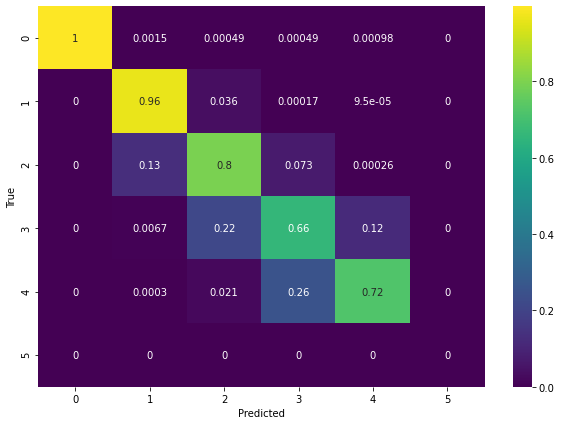

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True");